In [1]:
using LightGraphs, DifferentialEquations
using NLsolve
using Optim
using LaTeXStrings

include("NetworkOptimization.jl")
using NetworkOptimization
using OscillatorNetworks

using Memoize

using PyCall
using PyPlot

PyPlot.svg(true)

@pyimport seaborn as sns
@pyimport mpl_toolkits.axes_grid1 as ag
@pyimport matplotlib.gridspec as gs
@pyimport numpy as np
@pyimport scipy.interpolate as interpolate
@pyimport matplotlib.patheffects as path_effects

In [2]:
const TRIANG_UP = "\u25b2"
const TRIANG_UP_LG = "\u25b3"
const TRIANG_DOWN = "\u25bc"
const TRIANG_DOWN_LG = "\u25bd"
const TRIANG_LEFT = "\u25c0"
const TRIANG_LEFT_LG = "\u25c1"
const TRIANG_RIGHT = "\u25b6"
const TRIANG_RIGHT_LG = "\u25b7"
const STAR = "\u2605"
const STAR_LG = "\u2606"
const BOX = "\u25a0"
const BOX_LG = "\u25a1"
const DIAMOND = "\u25c6"
const DIAMOND_LG = "\u25c7"

"◇"

In [3]:
function draw_network_py(ax, topol::OscillatorNetworks.NetworkTopology, b; color="b", alpha=-1.0)
    points = topol.points

    for (e, width) = zip(edges(topol.g), b)
        x = points[e.src,:]
        y = points[e.dst,:]
        
        if alpha == -1.0
            α = width^2/maximum(b.^2)
        else
            α = alpha
        end
        
        ax[:plot]([x[1], y[1]], [x[2], y[2]], lw=2width, c=color, alpha=α)
    end
end

""" Take all the entries of b which are nonzero (greater than a threshold)
and shuffle them, return a copy of the shuffled array.
"""
function shuffle_nonzero(b)
    nonz = find(abs.(b) .> 1e-6)
    bb = copy(b)
        
    bb[nonz] = bb[shuffle(nonz)]
    return bb
end

""" Return an nxn matrix of a single sample of noise with the correlation
matrix R.
"""
function noise_background(R, shape)
    G = svdfact(R)
    A = G[:U]*diagm(sqrt.(G[:S]))
    
#     srand(42)
#     return reshape(A*randn(size(R)[1]), shape...)
    return A*randn(size(R)[1])
end

function draw_network_and_bg(ax, topol, b, R; cmap="RdBu_r", res=512, bg_method="nearest",
        bg_data=nothing, vmin=0.0, normalize_noise=true)
#     divider = ag.make_axes_locatable(ax)
#     cax = divider[:append_axes]("right", size="5%", pad="3%")
    
    if bg_data == nothing
        bg_R = R
        bg_pts = topol.points
    else
        bg_pts, bg_R = bg_data
    end
    
    n = Int64(sqrt(size(bg_R)[1]))

    noise_bg = noise_background(bg_R, (n, n))
    
    if normalize_noise
        noise_bg /= 1.1maximum(abs.(noise_bg))
    end
        
    x_min = minimum(bg_pts[:,1])
    x_max = maximum(bg_pts[:,1])
    
    dx = (x_max - x_min)/n

    y_min = minimum(bg_pts[:,2])
    y_max = maximum(bg_pts[:,2])
    
    dy = (y_max - y_min)/n
    
    X, Y = np.meshgrid(linspace(x_min - dx/4, x_max + dx/4, res), 
            linspace(y_min - dy/4, y_max + dy/4, res))
    
    C = interpolate.griddata(bg_pts, noise_bg, (X, Y), method=bg_method)
    
    if vmin == 0.0
        vmin = -max(abs(minimum(noise_bg)), abs(maximum(noise_bg)))
    end
    
    im = ax[:pcolormesh](X, Y, C, zorder=-100, cmap=cmap, vmin=vmin, vmax=-vmin, rasterized=true)
    
    # plot machines as nodes
#     ax[:scatter](topol.points[:,1], topol.points[:,2], c="w", s=10, zorder=100)
    

#     cb = f[:colorbar](im, cax=cax)
    # cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
#     cb[:ax][:set_title](L"$u_0$")

    draw_network_py(ax, topol, b, color="k", alpha=1.0)
    ax[:set_xticks]([])
    ax[:set_yticks]([])
    
    # return ScalarMappable for colorbar
    return im
end

function average_grid(xs, ys, values)
    all_xs = sort(unique(xs))
    all_ys = sort(unique(ys))
    
    n = length(all_xs)
    m = length(all_ys)
    
    mean_mat = zeros(n, m)
    std_mat = zeros(n, m)
        
    for i=1:n
        for j=1:m
            inds = find((xs .== all_xs[i]) .& (ys .== all_ys[j]))
            vals_at_xy = float.(values[inds])
            
            cleaned = float.(vals_at_xy[isfinite.(vals_at_xy)])
            if length(cleaned) == 0
                cleaned = float.([NaN])
            end

            mean_mat[i,j] = mean(cleaned)
            
            if length(cleaned) > 1
                std_mat[i,j] = std(cleaned)
            end
        end
    end
    
    all_xs, all_ys, mean_mat', std_mat'
end

average_grid (generic function with 1 method)

Swing equation solver for white noise
---

In [4]:
# Solve the nonlinear swing equation

function wn_swing_eq_sde_g(topol::OscillatorNetworks.NetworkTopology, t, u, b)
    du = zeros(2topol.verts)
    du[topol.verts+1:end] = 1.0
    
    return du
end

function wn_swing_eq_sde_f(topol::OscillatorNetworks.NetworkTopology, t, u, b, bg_factor=1.0)    
    uu = u[1:topol.verts]
    du = u[topol.verts+1:end]
            
    return vcat(du, -topol.γ*du - (topol.E*(b.*sin.(topol.E'*uu))) + bg_factor.*topol.P_ss)
end

function wn_ode_solution_sde(topol::OscillatorNetworks.NetworkTopology, b, R::Matrix, u0::Array{Float64}; dt=1e-3, tmax=100.0,
    seed=43, bg_factor=1.0)
    u0 = zeros(topol.verts)

    uu0 = [u0; 0similar(u0)]
    tspan = (0., tmax)
        
    fun = (u, p, t) -> wn_swing_eq_sde_f(topol, t, u, b, bg_factor)
    gun = (u, p, t) -> wn_swing_eq_sde_g(topol, t, u, b)
    
    n = topol.verts
    corr = [eye(n) zeros(n, n); zeros(n, n) R]
        
    W = CorrelatedWienerProcess(corr, 0.0, zeros(2n))
    prob = SDEProblem(fun, gun, uu0, tspan, noise=W, seed=seed);
    
    return solve(prob, EM(), dt=dt)
end

mod2pi2(x) = rem2pi(x, RoundNearest)

δs_from_ret(ret) = hcat([mod2pi2.(u[1:topol.verts]) for u in ret.u]...)

function time_average(x::Matrix, t)
    dt = t[2] - t[1]
    ints = dt*cumsum(x, 2)
    
    for i=1:size(ints)[1]
        ints[i,:] ./= t
    end
    
    ints[:,1] = 0.0
    
    return ints
end

function time_average(x::Vector, t)
    dt = t[2] - t[1]
    ints = dt*cumsum(x)./t
    
    ints[1] = 0.0
    
    return ints
end

""" Compute the angular time average, i.e., Arg( ⟨ e^(iδ) ⟩ )
"""
function angular_time_avg(x::Union{Vector, Matrix}, t)
    return angle.(time_average(cis.(x), t))
end

ε²_from_δ(δ, ret) = sum((mod2pi2.(δ .- angular_time_avg(δ, ret.t))).^2, 1)[1,:]

ε²_from_δ (generic function with 1 method)

Swing equation solver for OU noise
---

In [5]:
# noise term. basically just scaling.
function ou_swing_eq_sde_g(topol::OscillatorNetworks.NetworkTopology, R, t, u, b)
    # scaling the input stochasticity
    # last component of eqns is ornstein-uhlenbeck, rest has no stochastic component
    du = zeros(3topol.verts)
    du[2topol.verts+1:end] = 1.0
    
    return du
end

function ou_swing_eq_sde_f(topol::OscillatorNetworks.NetworkTopology, R, A, t, u, b)
    uu = u[1:topol.verts]
    du = u[topol.verts+1:2topol.verts]
    ou = u[2topol.verts+1:end]
    
    return vcat(du, -topol.γ*du - (topol.E*(b.*sin.(topol.E'*uu))) + A*ou, zeros(topol.verts))
end

function ou_ode_solution_sde(topol::OscillatorNetworks.NetworkTopology, b::Array{Float64}, 
            C::NetworkOptimization.OrnsteinUhlenbeckCorrelations; dt=1e-3, tmax=150.0)
    u0 = zeros(3topol.verts)
    tspan = (0., tmax)
    
    # construct matrix whose square is the correlation matrix R, A A^T = R
    γ = svdfact(C.R)
    A = γ[:U]*Diagonal(sqrt.(γ[:S]))
    
    fun = (u, p, t) -> ou_swing_eq_sde_f(topol, C.R, A, t, u, b)
    gun = (u, p, t) -> ou_swing_eq_sde_g(topol, C.R, t, u, b)
    
    n = topol.verts
    W = OrnsteinUhlenbeckProcess(C.κ, 0.0, sqrt(2C.κ), 0.0, zeros(3topol.verts))

    prob = SDEProblem(fun, gun, u0, tspan, noise=W, seed=43);
    
    return solve(prob, EM(), dt=dt, adaptive=false)
end

ou_ode_solution_sde (generic function with 1 method)

Figure 1
=====

In [42]:
# generate white noise time series
srand(42)
topol = OscillatorNetworks.triang_grid_network(10, 0.5)
R = OscillatorNetworks.uncorrelated_correlation_matrix(topol, project=true)
R_c = OscillatorNetworks.uncorrelated_correlation_matrix(topol, project=false)

bg_points = OscillatorNetworks.triang_grid_points(10)

function optimize_wn_general(topol, R, α, b_tot)
    rhs = NetworkOptimization.white_noise_general
    b₀ = rand(topol.edges)
    b_total = float(topol.edges)*b_tot

    b_uniform = (b_total.*ones(b₀)/length(b₀)).^(1./α)
    b₀ *= (b_total/sum(b₀.^α)).^(1./α)

    b_final, δ_final, change, change_δ, res = NetworkOptimization.optimize_general_network(topol, rhs, (R,),
        α, b₀, b_total, intermediate_diffs=false)
    
    println("final Δ: ", change, ", δ converged: ", converged(res))
    
    obj = NetworkOptimization.total_variance_white_noise(topol, R, b_final.*cos.(topol.E'*δ_final))
    
    δ_uniform = OscillatorNetworks.ss_power_angles(b_uniform, topol)
    obj_uniform = NetworkOptimization.total_variance_white_noise(topol, R, b_uniform.*cos.(topol.E'*δ_uniform))
    
    b_shuffled = shuffle_nonzero(b_final)
    δ_shuffled = OscillatorNetworks.ss_power_angles(b_shuffled, topol)
    obj_shuffled = NetworkOptimization.total_variance_white_noise(topol, R, b_shuffled.*cos.(topol.E'*δ_shuffled))
     
    return b_final, b_uniform, obj, obj_uniform, obj_shuffled, δ_final, δ_uniform
end

α_1 = 0.5
α_2 = 0.25
α_3 = 0.25
α_4 = 1.05

B_1 = 1.0
B_2 = 1.0
B_3 = 0.4
B_4 = 1.0

b_final_1, b_uniform_1, obj_1, obj_uniform_1, obj_shuffled_1, δ_1, δ_uniform_1 = optimize_wn_general(topol, R, α_1, B_1)
b_final_2, b_uniform_2, obj_2, obj_uniform_2, obj_shuffled_2, δ_2, δ_uniform_2 = optimize_wn_general(topol, R, α_2, B_2)
b_final_3, _, obj_3, _, _, _, _ = optimize_wn_general(topol, R, α_3, B_3)
b_final_4, _, obj_4, _, _, _, _ = optimize_wn_general(topol, R, α_4, B_4)

final Δ: 9.8415465132404e-7, δ converged: true
final Δ: 9.834097809192617e-7, δ converged: true
final Δ: 9.088897573756973e-7, δ converged: true
final Δ: 9.713191093303904e-7, δ converged: true


([1.53277, 1.31077, 1.59564, 0.738913, 0.864578, 1.05, 1.7828, 0.379028, 1.79543, 1.10581  …  1.31075, 1.26191, 1.66536, 1.71574, 1.81607, 1.82393, 1.79555, 1.78291, 1.59571, 1.53282], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.4174854730969706, 0.4340728901861527, 0.4545074269707116, [0.0, -0.00060785, -0.00228267, -0.00491581, -0.00509259, -0.0149042, -0.0191866, -0.0219805, -0.0290478, -0.0218848  …  0.00717029, 0.0127227, 0.00110978, -0.00574766, -0.0101745, -0.017273, -0.0264935, -0.0356524, -0.0427391, -0.0489276], [0.0, 0.000309685, -0.000791351, -0.00398751, -0.00341767, -0.0157194, -0.0198607, -0.0222189, -0.0304892, -0.0215911  …  0.00875911, 0.0158919, 0.00205041, -0.00528634, -0.0101021, -0.0183247, -0.0295241, -0.0406564, -0.0479788, -0.0558192])

In [43]:
obj_1, obj_2, obj_3, obj_4, obj_uniform_1

(0.2685980623493818, 0.06183468934199951, 2.3827880035237006, 0.4174854730969706, 0.4340728901861527)

In [23]:
# Solve swing equation with identical noise
dt = 1e-3
tmax = 150.0

ret_1 = wn_ode_solution_sde(topol, b_final_1, R, δ_1, dt=dt, tmax=tmax)
ret_uniform_1 = wn_ode_solution_sde(topol, b_uniform_1, R, δ_uniform_1, dt=dt, tmax=tmax);

ret_2 = wn_ode_solution_sde(topol, b_final_2, R, δ_1, dt=dt, tmax=tmax);
ret_uniform_2 = wn_ode_solution_sde(topol, b_uniform_2, R, δ_uniform_2, dt=dt, tmax=tmax);

In [24]:
# fluctuations
ε_1 = ε²_from_δ(δs_from_ret(ret_1), ret_1)
ε_uniform_1 = ε²_from_δ(δs_from_ret(ret_uniform_1), ret_uniform_1);

ε_2 = ε²_from_δ(δs_from_ret(ret_2), ret_2)
ε_uniform_2 = ε²_from_δ(δs_from_ret(ret_uniform_2), ret_uniform_2);

# time average of fluctuations
avg_ε_1 = time_average(ε_1, ret_1.t)
avg_ε_uniform_1 = time_average(ε_uniform_1, ret_uniform_1.t)

avg_ε_2 = time_average(ε_2, ret_2.t)
avg_ε_uniform_2 = time_average(ε_uniform_2, ret_uniform_2.t);

In [25]:
# read in phase space data
phase_space = readcsv("data/phase_diagram_white_noise_triang_10.csv")

ps_objective = phase_space[:,3]

fin = isfinite.(ps_objective)

ps_α = phase_space[fin,1]
ps_b_tot = phase_space[fin,2]
# ps_objective = phase_space[fin,3]
ps_loops = phase_space[fin,4]
ps_max_loops = phase_space[fin,5]
ps_kuramoto = phase_space[fin,6]
ps_mean_weighted_deg = phase_space[fin,7]
ps_mean_deg = phase_space[fin,9]

ps_objective = ps_objective[fin]

ps_loop_fraction = ps_loops./ps_max_loops;

In [26]:
unique_α, unique_b_tot, mean_objective, std_objective = average_grid(ps_α, ps_b_tot, ps_objective)
unique_α, unique_b_tot, mean_loops, std_loops = average_grid(ps_α, ps_b_tot, ps_loop_fraction)
unique_α, unique_b_tot, mean_deg, std_deg = average_grid(ps_α, ps_b_tot, ps_mean_weighted_deg)

mean_loops[isnan.(mean_objective)] = NaN
mean_deg[isnan.(mean_objective)] = NaN

b_final_results = readcsv("data/phase_diagram_white_noise_triang_10_networks.csv")
b_final_means = mean(b_final_results, 2)[:,1]
b_final_stds = std(b_final_results, 2)[:,1]

b_final_std_ratio = b_final_stds./b_final_means

unique_α, unique_b_tot, mean_b_ratio, std_b_ratio = average_grid(ps_α, ps_b_tot, b_final_std_ratio)

mean_b_ratio[isnan.(mean_objective)] = NaN

NaN

In [27]:
# read in range of validity simulations and properly normalize
norm_const = 64*π^2/3

predict_data_1 = readcsv("data/white_noise_8_alpha_0.5_simulations_predictions_close_to_synchrony_C_0.2.csv")
order_pm_1 = predict_data_1[:,4]
simulations_1 = predict_data_1[:,2]/norm_const
predictions_1 = predict_data_1[:,3]/norm_const;
facts_1 = predict_data_1[:,1]

predict_data_2 = readcsv("data/white_noise_8_alpha_0.5_simulations_predictions_close_to_synchrony_C_0.4.csv")
order_pm_2 = predict_data_2[:,4]
simulations_2 = predict_data_2[:,2]/norm_const
predictions_2 = predict_data_2[:,3]/norm_const;
facts_2 = predict_data_2[:,1]


predict_data_3 = readcsv("data/white_noise_8_alpha_0.25_simulations_predictions_close_to_synchrony_C_0.4.csv")
order_pm_3 = predict_data_3[:,4]
simulations_3 = predict_data_3[:,2]/norm_const
predictions_3 = predict_data_3[:,3]/norm_const;
facts_3 = predict_data_3[:,1]


predict_data_4 = readcsv("data/white_noise_8_alpha_0.75_simulations_predictions_close_to_synchrony_C_0.1.csv")
order_pm_4 = predict_data_4[:,4]
simulations_4 = predict_data_4[:,2]/norm_const
predictions_4 = predict_data_4[:,3]/norm_const;
facts_4 = predict_data_4[:,1]


predict_data_5 = readcsv("data/white_noise_8_alpha_1.25_simulations_predictions_close_to_synchrony_C_0.05.csv")
order_pm_5 = predict_data_5[:,4]
simulations_5 = predict_data_5[:,2]/norm_const
predictions_5 = predict_data_5[:,3]/norm_const;
facts_5 = predict_data_5[:,1];


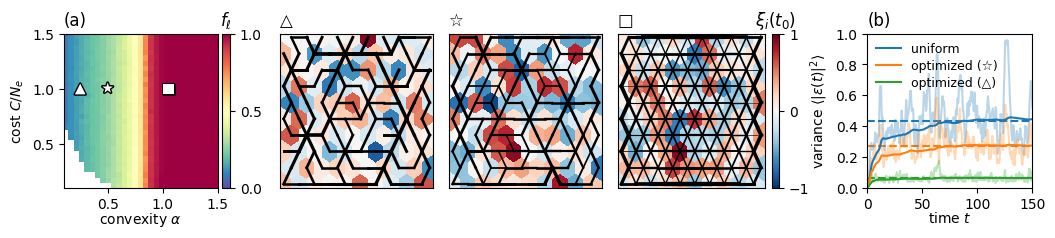

In [44]:
# Figure 1 v2
f = figure(figsize=(12.5, 2.))

# outer = gs.GridSpec(2, 1, f, height_ratios=[5, 3], hspace=0.4)
# upper = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], wspace=0.35)
# lower = gs.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[2], width_ratios=[95, 95, 95, 100], wspace=0.1)

grid = gs.GridSpec(1, 2, width_ratios=[6.5, 1.5], wspace=0.2)
lm = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[1], wspace=0.15, width_ratios=[1, 3])
left = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=lm[1], wspace=0.1)
mid = gs.GridSpecFromSubplotSpec(1, 3, subplot_spec=lm[2], wspace=0.1, width_ratios=[95, 95, 100])

right = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[2])


################ Time Series Plot
ax_a = subplot(right[1])

l_uni = ax_a[:plot](ret_uniform_1.t, ε_uniform_1, alpha=0.3)
l_opt_1 = ax_a[:plot](ret_1.t, ε_1, alpha=0.3)
l_opt_2 = ax_a[:plot](ret_2.t, ε_2, alpha=0.3)

ax_a[:plot](ret_uniform_1.t, avg_ε_uniform_1, color=l_uni[1][:get_c](), label="uniform")
ax_a[:plot](ret_1.t, avg_ε_1, color=l_opt_1[1][:get_c](), label="optimized ($(STAR_LG))")
ax_a[:plot](ret_2.t, avg_ε_2,  color=l_opt_2[1][:get_c](), label="optimized ($(TRIANG_UP_LG))")

# predictions
ax_a[:axhline](obj_uniform_1, color=l_uni[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_1, color=l_opt_1[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_2, color=l_opt_2[1][:get_c](), ls="--", lw=1.5, zorder=-100)

ax_a[:set_ylim](0, 1.0)
ax_a[:set_xlim](0, 150.0)

ax_a[:legend](loc="best", frameon=false, labelspacing=0.3, fontsize=9, borderaxespad=0.3)

ax_a[:set_xlabel](L"time $t$", labelpad=-1)
ax_a[:set_ylabel](L"variance $\langle \|\varepsilon(t) \|^2 \rangle$")
ax_a[:set_title]("(b)", loc="left")




# ################### Region of validity
# ax_e = subplot(upper[2])

# ax_e[:set_title]("(b)", loc="left")

# ax_e[:set_ylabel](L"\left.\frac{1}{T}\int_0^T \|\vec\varepsilon(t)\|^2 dt \right/ \left(N\pi^2/3\right)",
#             labelpad=-0.3)
# ax_e[:set_xlabel](L"\left.\langle \| \vec\varepsilon(t) \|^2 \rangle \right/ \left(N\pi^2/3\right)")

# ax_e[:plot](linspace(0., 1), linspace(0, 1), "k--", lw=1.5)

# ax_e[:plot](predictions_3, simulations_3, "o", mfc="none", label=L"\alpha=0.25", ms=6)
# ax_e[:plot](predictions_1, simulations_1, ">", mfc="none", label=L"\alpha=0.5", ms=6)
# # # ax_e[:plot](predictions_2, simulations_2, "kd", mfc="none", label=L"\alpha=0.5, C=0.4N_e")
# ax_e[:plot](predictions_4, simulations_4, "^", mfc="none", label=L"\alpha=0.75", ms=6)
# ax_e[:plot](predictions_5, simulations_5, "<", mfc="none", label=L"\alpha=1.25", ms=6)

# ax_e[:set_xlim](0, 0.4)
# ax_e[:set_ylim](0, 0.4)

# ax_e[:legend](loc="best", borderaxespad=0.2, borderpad=0.1, handletextpad=0.05, labelspacing=0.3, 
#     frameon=false, fontsize=10)




############ Topology phase space
ax_d = subplot(left[1])

divider = ag.make_axes_locatable(ax_d)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α, unique_b_tot)
im = ax_d[:pcolormesh](X, Y, mean_loops, cmap="Spectral_r", vmin=0.0)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.5, 1])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

# plot locations of networks
# ax_d[:plot]([α_1], [B_1], "*", c="w", mec="k", ms=10)
ax_d[:text](α_1*1.0, B_1*1.0, STAR, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_2], [B_2], "*", c="w", mec="k", ms=10)
ax_d[:text](α_2*1.0, B_2*1.0, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_3], [B_3], "*", c="w", mec="k", ms=10)
# ax_d[:text](α_3*1.0, B_3*1.0, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
#                        path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_4], [B_4], "*", c="w", mec="k", ms=10)
ax_d[:text](α_4*1.0, B_4*1.0, BOX, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:set_xticks]([0, 1.5])
# ax_d[:set_yticks]([0, 1.5])

ax_d[:locator_params](axis="y", nbins=5)

ax_d[:set_xlabel](L"convexity $\alpha$", labelpad=-1)
ax_d[:set_ylabel](L"cost $C/N_e$")
ax_d[:set_title]("(a)", loc="left")



##################### Example networks
# srand(42)
ax_e = subplot(mid[2])

# draw_network_and_bg(ax_e, topol, b_final_1.^0.5, R)
# draw_network_py(ax_e, topol, 0.5b_final_1.^α_1, color="k", alpha=1.0)
im = draw_network_and_bg(ax_e, topol, 0.5b_final_1.^α_1, R_c, vmin=-1)
ax_e[:set_xticks]([])
ax_e[:set_yticks]([])

ax_e[:set_title](STAR_LG, loc="left")
# ax_e[:set_title](L"\alpha = 0.5")


ax_f = subplot(mid[1])

# draw_network_py(ax_f, topol, 0.5b_final_2.^α_2, color="k", alpha=1.0)
im = draw_network_and_bg(ax_f, topol, 0.5b_final_2.^α_2, R_c, vmin=-1)

ax_f[:set_xticks]([])
ax_f[:set_yticks]([])

ax_f[:set_title](TRIANG_UP_LG, loc="left")
# ax_f[:set_title](L"\alpha = 0.25")

# ax_nw_3 = subplot(mid[2])

# draw_network_py(ax_nw_3, topol, b_final_3.^α_3, color="k", alpha=1.0)
# im = draw_network_and_bg(ax_nw_3, topol, 1.25b_final_3.^α_3, R, vmin=-1)

# ax_nw_3[:set_xticks]([])
# ax_nw_3[:set_yticks]([])

# ax_nw_3[:set_title](TRIANG_DOWN_LG, loc="left")


ax_nw_4 = subplot(mid[3])

# draw_network_py(ax_nw_4, topol, b_final_4.^α_4, color="k", alpha=1.0)
im = draw_network_and_bg(ax_nw_4, topol, 0.75b_final_4.^α_4, R_c, vmin=-1)

ax_nw_4[:set_xticks]([])
ax_nw_4[:set_yticks]([])

ax_nw_4[:set_title](BOX_LG, loc="left")

# colorbar
divider = ag.make_axes_locatable(ax_nw_4)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1, 0, 1])
cax[:set_title](L"\xi_i(t_0)")

########### SAVE
f[:tight_layout]()
f[:savefig]("paper_figs/figure1_v4.pdf", bbox_inches="tight")

Figure 2
=====

In [32]:
srand(42)
function optimize_wn_sync(topol, R, α)
    rhs = NetworkOptimization.white_noise_synchronous
    b₀ = rand(topol.edges)
    b_total = float(topol.edges)

    b_uniform = (b_total.*ones(b₀)/length(b₀)).^(1./α)
    b₀ *= (b_total/sum(b₀.^α)).^(1./α)

    b_final, change = NetworkOptimization.optimize_synchronous_network(topol, rhs, (R,),
        α, b₀, b_total, intermediate_diffs=false)
    
    println("final Δ: ", change)
    
    obj = NetworkOptimization.total_variance_white_noise(topol, R, b_final)
    obj_uniform = NetworkOptimization.total_variance_white_noise(topol, R, b_uniform)
    
    b_shuffled = shuffle_nonzero(b_final)
    obj_shuffled = NetworkOptimization.total_variance_white_noise(topol, R, b_shuffled)
     
    return b_final, b_uniform, obj, obj_uniform, obj_shuffled
end

function optimize_ou_sync(topol, R, α, κ)
    rhs = NetworkOptimization.ornstein_uhlenbeck_synchronous
    b₀ = rand(topol.edges)
    b_total = float(topol.edges)

    b_uniform = (b_total.*ones(b₀)/length(b₀)).^(1./α)
    b₀ *= (b_total/sum(b₀.^α)).^(1./α)
    
    C = NetworkOptimization.OrnsteinUhlenbeckCorrelations(R, κ)

    b_final, change = NetworkOptimization.optimize_synchronous_network(topol, rhs, (C,),
        α, b₀, b_total, intermediate_diffs=false)
    
    println("final Δ: ", change)
    
    obj = NetworkOptimization.total_variance_ornstein_uhlenbeck(topol, C, b_final)
    obj_uniform = NetworkOptimization.total_variance_ornstein_uhlenbeck(topol, C, b_uniform)
    
    b_shuffled = shuffle_nonzero(b_final)
    obj_shuffled = NetworkOptimization.total_variance_ornstein_uhlenbeck(topol, C, b_shuffled)
     
    return b_final, b_uniform, obj, obj_uniform, obj_shuffled
end

α_ou_1 = 0.5
α_ou_2 = 0.5

τ_ou_1 = 0.1
τ_ou_2 = 10.0


# Ornstein-Uhlenbeck time correlations
b_final_ou_1, b_uniform_ou_1, obj_ou_1, obj_uniform_ou_1, obj_shuffled_ou_1 = optimize_ou_sync(topol, R, α_ou_1, 1./τ_ou_1*topol.γ)
b_final_ou_2, b_uniform_ou_2, obj_ou_2, obj_uniform_ou_2, obj_shuffled_ou_2 = optimize_ou_sync(topol, R, α_ou_2, 1./τ_ou_2*topol.γ)


α_ga_1 = 0.5
α_ga_2 = 0.5

σ_ga_1 = 0.1
σ_ga_2 = 0.3

R_ga_1 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_1)
R_ga_1_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_1, project=false)

R_ga_2 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_2)
R_ga_2_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_2, project=false)


# Gaussian-Isotropic space correlations
b_final_ga_1, b_uniform_ga_1, obj_ga_1, obj_uniform_ga_1, obj_shuffled_ga_1 = optimize_wn_sync(topol, R_ga_1, α_ga_1)
b_final_ga_2, b_uniform_ga_2, obj_ga_2, obj_uniform_ga_2, obj_shuffled_ga_2 = optimize_wn_sync(topol, R_ga_2, α_ga_1)

final Δ: 9.995404364023024e-7
final Δ: 9.52744991218573e-7
final Δ: 9.665193775010023e-7
final Δ: 9.97920979774032e-7


([1.90343, 0.0, 0.0, 0.0, 0.0, 4.4911, 1.74172, 0.0, 1.66173, 2.8043  …  0.0, 1.68111, 3.59276, 0.0, 1.69162, 1.66173, 0.0, 0.0, 0.0, 1.90343], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.4332960753714703, 3.8601478958009365, 5.1464680045475495)

In [33]:
# read in phase space data for time correlations
phase_space = readcsv("data/phase_diagram_ornstein_uhlenbeck_triang_10.csv")

ps_α = phase_space[:,1]
ps_τ = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_α_ou, unique_τ_ou, mean_objective_ou, std_objective_ou = average_grid(ps_α, ps_τ, ps_objective)
unique_α_ou, unique_τ_ou, mean_loops_ou, std_loops_ou = average_grid(ps_α, ps_τ, ps_loop_fraction)
unique_α_ou, unique_τ_ou, mean_deg_ou, std_deg_ou = average_grid(ps_α, ps_τ, ps_mean_weighted_deg)


# compute the weight uniformity
b_final_results_ou = readcsv("data/phase_diagram_ornstein_uhlenbeck_triang_10_networks.csv")
b_final_means_ou = mean(b_final_results_ou, 2)[:,1]
b_final_stds_ou = std(b_final_results_ou, 2)[:,1]

b_final_std_ratio_ou = b_final_stds_ou./b_final_means_ou

unique_α_ou, unique_τ_ou, mean_b_ratio_ou, std_b_ratio_ou = average_grid(ps_α, ps_τ, b_final_std_ratio_ou)
unique_τ_ou *= 0.5

30-element Array{Float64,1}:
   0.01     
   0.0137382
   0.0188739
   0.0259294
   0.0356225
   0.048939 
   0.0672336
   0.0923671
   0.126896 
   0.174333 
   0.239503 
   0.329034 
   0.452035 
   ⋮        
   3.0392   
   4.17532  
   5.73615  
   7.88046  
  10.8264   
  14.8735   
  20.4336   
  28.0722   
  38.5662   
  52.9832   
  72.7895   
 100.0      

In [34]:
# read in phase space data for gaussian spatial
phase_space = readcsv("data/phase_diagram_gaussian_triang_10.csv")
netw_size_ga = 10.0

ps_α = phase_space[:,1]
ps_σ = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_α_ga, unique_σ_ga, mean_objective_ga, std_objective_ga = average_grid(ps_α, ps_σ, ps_objective)
unique_α_ga, unique_σ_ga, mean_loops_ga, std_loops_ga = average_grid(ps_α, ps_σ, ps_loop_fraction)
unique_α_ga, unique_σ_ga, mean_deg_ga, std_deg_ga = average_grid(ps_α, ps_σ, ps_mean_deg)

# compute the weight uniformity
b_final_results_ga = readcsv("data/phase_diagram_gaussian_triang_10_networks.csv")
b_final_means_ga = mean(b_final_results_ga, 2)[:,1]
b_final_stds_ga = std(b_final_results_ga, 2)[:,1]

b_final_std_ratio_ga = b_final_stds_ga./b_final_means_ga

unique_α_ga, unique_σ_ga, mean_b_ratio_ga, std_b_ratio_ga = average_grid(ps_α, ps_σ, b_final_std_ratio_ga)

unique_σ_ga *= netw_size_ga;

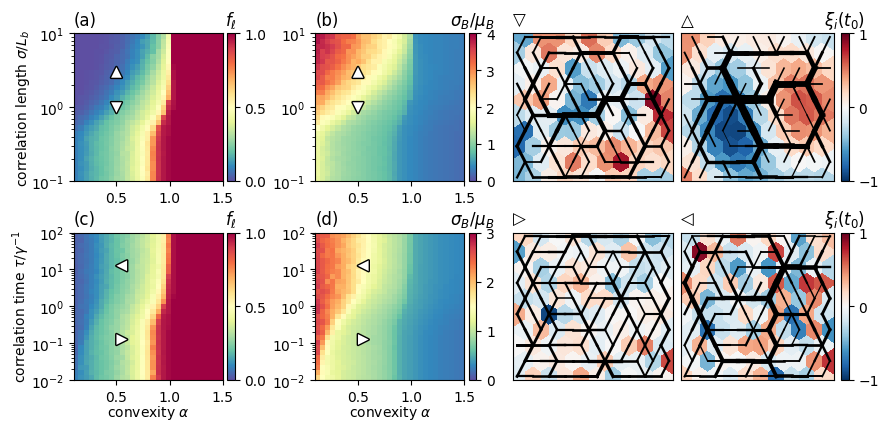

In [36]:
# f, axs = subplots(2, 4, figsize=(9., 4.))
# f = figure(figsize=(9, 4.))
f = figure(figsize=(10., 4.5))
top_base = gs.GridSpec(2, 2, f, hspace=0.35, wspace=0.1, width_ratios=[1.2, 1])

axs_ps_bot = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[1], wspace=0.5)
axs_netws_bot = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[2], wspace=0.05, width_ratios=[95, 100])

axs_ps_top = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[3], wspace=0.5)
axs_netws_top = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[4], wspace=0.05, width_ratios=[95, 100])


##### phase diagram loop topology Ornstein-Uhlenbeck
ax_b = subplot(axs_ps_top[1,1])
ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
ax_b[:set_ylabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
ax_b[:set_title]("(c)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ou, unique_τ_ou)
im = ax_b[:pcolormesh](X, Y, mean_loops_ou, cmap="Spectral_r", vmin=0.0)#, vmin=0, vmax=5)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.5, 1])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ou_1], [τ_ou_1], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, τ_ou_1*1.0, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:semilogy]([α_ou_2], [τ_ou_2], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, τ_ou_2*1.0, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:set_xticklabels]([])


##### phase diagram weight uniformity Ornstein-Uhlenbeck
ax_b = subplot(axs_ps_top[1,2])
ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
# ax_b[:set_ylabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
ax_b[:set_title]("(d)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ou, unique_τ_ou)
im = ax_b[:pcolormesh](X, Y, mean_b_ratio_ou, cmap="Spectral_r", vmin=0.0, vmax=3.0)#, vmin=0, vmax=5)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 1.0, 2.0, 3.0])
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ou_1], [τ_ou_1], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, τ_ou_1*1.0, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:semilogy]([α_ou_2], [τ_ou_2], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, τ_ou_2*1.0, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:set_xticklabels]([])
# ax_b[:set_yticklabels]([])

##### example networks Ornstein-Uhlenbeck
srand(42)
ax_c = subplot(axs_netws_top[1])
# draw_network_py(ax_c, topol, b_final_ou_1.^0.5, color="k", alpha=1.0)
im = draw_network_and_bg(ax_c, topol, 0.5b_final_ou_1.^α_ou_1, R_c, vmin=-1)
ax_c[:set_xticks]([])
ax_c[:set_yticks]([])

ax_c[:set_title](TRIANG_RIGHT_LG, loc="left")
# ax_c[:set_title](L"\tau = 100.0", fontsize=10)

ax_d = subplot(axs_netws_top[2])
# draw_network_py(ax_d, topol, b_final_ou_2.^0.5, color="k", alpha=1.0)
im = draw_network_and_bg(ax_d, topol, 0.5b_final_ou_2.^α_ou_2, R_c, vmin=-1)

ax_d[:set_title](TRIANG_LEFT_LG, loc="left")
# ax_d[:set_title](L"\tau = 0.01", fontsize=10)
ax_d[:set_xticks]([])
ax_d[:set_yticks]([])

# colorbar
divider = ag.make_axes_locatable(ax_d)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1,  0.0, 1])
cax[:set_title](L"\xi_i(t_0)")


######## phase diagram topology Gaussian Spatial
ax_b = subplot(axs_ps_bot[1])
# ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
ax_b[:set_ylabel](L"correlation length $\sigma/L_b$", labelpad=-0.5)
ax_b[:set_title]("(a)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ga, unique_σ_ga)
im = ax_b[:pcolormesh](X, Y, mean_loops_ga, cmap="Spectral_r")#, vmin=0, vmax=5)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.5, 1])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ga_1], [σ_ga_1*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, σ_ga_1*10, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:semilogy]([α_ga_2], [σ_ga_2*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, σ_ga_2*10, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:set_xticklabels]([])

####### phase diagram weight uniformity Gaussian Spatial
ax_b = subplot(axs_ps_bot[2])
# ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
# ax_b[:set_ylabel](L"correlation length $\log_{10}\sigma/L_b$")
ax_b[:set_title]("(b)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ga, unique_σ_ga)
im = ax_b[:pcolormesh](X, Y, mean_b_ratio_ga, cmap="Spectral_r", vmin=0, vmax=4)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 1.0, 2.0, 3.0, 4])
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ga_1], [σ_ga_1*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, σ_ga_1*10, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:semilogy]([α_ga_2], [σ_ga_2*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, σ_ga_2*10, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:set_xticklabels]([])
# ax_b[:set_yticklabels]([])

###### Example networks Gaussian Spatial
srand(43)
ax_c = subplot(axs_netws_bot[1])
bg_R = OscillatorNetworks.isotropic_gaussian_correlation_matrix(bg_points, σ_ga_1, project=false)
im = draw_network_and_bg(ax_c, topol, 0.5b_final_ga_1.^0.5, R_ga_1_c; bg_method="nearest", bg_data=(bg_points, bg_R), vmin=-1)
ax_c[:set_title](TRIANG_DOWN_LG, loc="left")

ax_c = subplot(axs_netws_bot[2])
bg_R = OscillatorNetworks.isotropic_gaussian_correlation_matrix(bg_points, σ_ga_2, project=false)
im = draw_network_and_bg(ax_c, topol, 0.5b_final_ga_2.^0.5, R_ga_1_c; bg_method="nearest", bg_data=(bg_points, bg_R), vmin=-1)
ax_c[:set_title](TRIANG_UP_LG, loc="left")

# colorbar
divider = ag.make_axes_locatable(ax_c)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1, 0, 1])
cax[:set_title](L"\xi_i(t_0)")


f[:tight_layout]()
f[:savefig]("paper_figs/figure2_v3.pdf", bbox_inches="tight")

Figure 3
====

In [51]:
α_st_1 = 0.5
α_st_2 = 0.5
α_st_3 = 0.5

σ_st_1 = 0.3/10
σ_st_2 = 0.3/10
σ_st_3 = 1.2/10

τ_st_1 = 0.1
τ_st_2 = 10.0
τ_st_3 = 1.0

R_st_1 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_1)
R_st_2 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_2)
R_st_3 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_3)

R_st_1_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_1, project=false)
R_st_2_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_2, project=false)
R_st_3_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_3, project=false)

# combined
b_final_st_1, _, obj_st_1, _, _ = optimize_ou_sync(topol, R_st_1, α_st_1, 1./τ_st_1*topol.γ)
b_final_st_2, _, obj_st_2, _, _ = optimize_ou_sync(topol, R_st_2, α_st_2, 1./τ_st_2*topol.γ)
b_final_st_3, _, obj_st_3, _, _ = optimize_ou_sync(topol, R_st_3, α_st_3, 1./τ_st_3*topol.γ)

final Δ: 9.806818721340098e-7
final Δ: 9.960584820074495e-7
final Δ: 9.902081867331097e-7


([2.19191, 0.0, 0.0, 1.98645, 0.0, 7.55415, 0.0, 2.03435, 2.20824, 0.0  …  0.453758, 0.700353, 2.46388, 1.96078, 1.38759, 1.0124, 1.57341, 0.0, 0.0, 1.88743], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.1468081215505546, 3.565159447674221, 3.83136100396281)

In [52]:
# read in phase space data
phase_space = readcsv("data/phase_diagram_spatiotemporal_triang_10.csv")

ps_τ = phase_space[:,1]
ps_σ = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_τ, unique_σ, mean_objective, std_objective = average_grid(ps_τ, ps_σ, ps_objective)
unique_τ, unique_σ, mean_loops, std_loops = average_grid(ps_τ, ps_σ, ps_loop_fraction)
unique_τ, unique_σ, mean_deg, std_deg = average_grid(ps_τ, ps_σ, ps_mean_deg)

# compute the weight uniformity
b_final_results = readcsv("data/phase_diagram_spatiotemporal_triang_10_networks.csv")
b_final_means = mean(b_final_results, 2)[:,1]
b_final_stds = std(b_final_results, 2)[:,1]

b_final_std_ratio = b_final_stds./b_final_means

unique_τ, unique_σ, mean_b_ratio, std_b_ratio = average_grid(ps_τ, ps_σ, b_final_std_ratio)
unique_τ *= 0.5
unique_σ *= 10

# read in range of validity simulations and properly normalize
norm_const = 64*π^2/3

predict_data_1 = readcsv("data/white_noise_8_alpha_0.5_simulations_predictions_close_to_synchrony_C_0.2.csv")
order_pm_1 = predict_data_1[:,4]
simulations_1 = predict_data_1[:,2]/norm_const
predictions_1 = predict_data_1[:,3]/norm_const;

predict_data_2 = readcsv("data/white_noise_8_alpha_0.5_simulations_predictions_close_to_synchrony_C_0.4.csv")
order_pm_2 = predict_data_2[:,4]
simulations_2 = predict_data_2[:,2]/norm_const
predictions_2 = predict_data_2[:,3]/norm_const;

predict_data_3 = readcsv("data/white_noise_8_alpha_0.25_simulations_predictions_close_to_synchrony_C_0.4.csv")
order_pm_3 = predict_data_3[:,4]
simulations_3 = predict_data_3[:,2]/norm_const
predictions_3 = predict_data_3[:,3]/norm_const;

predict_data_4 = readcsv("data/white_noise_8_alpha_0.75_simulations_predictions_close_to_synchrony_C_0.1.csv")
order_pm_4 = predict_data_4[:,4]
simulations_4 = predict_data_4[:,2]/norm_const
predictions_4 = predict_data_4[:,3]/norm_const;

predict_data_5 = readcsv("data/white_noise_8_alpha_1.25_simulations_predictions_close_to_synchrony_C_0.05.csv")
order_pm_5 = predict_data_5[:,4]
simulations_5 = predict_data_5[:,2]/norm_const
predictions_5 = predict_data_5[:,3]/norm_const;

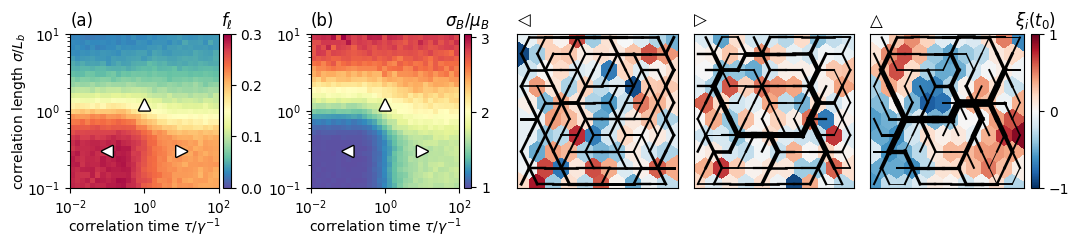

In [53]:
# Figure 3 v3
f = figure(figsize=(12.5, 2))

# outer = gs.GridSpec(2, 1, f, hspace=0.4, wspace=0.3, height_ratios=[1.3, 1.0])
# inner1 = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], hspace=0.3, wspace=0.42)
# inner2 = gs.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[2], hspace=0.3, wspace=0.1, width_ratios=[95, 95, 100])

grid = gs.GridSpec(1, 2, width_ratios=[2.5, 3.25], wspace=0.1)
left = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[1], wspace=0.5)
right = gs.GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[2], wspace=0.1, width_ratios=[95, 95, 100])


########## Phase diagram topology
ax_a = subplot(left[1])

ax_a[:set_xlabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
ax_a[:set_ylabel](L"correlation length $\sigma/L_b$", labelpad=-0.5)
ax_a[:set_title]("(a)", loc="left")

divider = ag.make_axes_locatable(ax_a)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_τ, unique_σ)
im = ax_a[:pcolormesh](X, Y, mean_loops, cmap="Spectral_r", vmin=0, vmax=0.3)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.1, 0.2, 0.3])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_a[:set_xscale]("log")
ax_a[:set_yscale]("log")

# ax_a[:loglog]([τ_st_1], [σ_st_1*10], "*", c="w", mec="k", ms=10)
ax_a[:text](τ_st_1*1.0, σ_st_1*10, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_a[:loglog]([τ_st_2], [σ_st_2*10], "*", c="w", mec="k", ms=10)
ax_a[:text](τ_st_2*1.0, σ_st_2*10, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_a[:loglog]([τ_st_3], [σ_st_3*10], "*", c="w", mec="k", ms=10)
ax_a[:text](τ_st_3*1.0, σ_st_3*10, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

########## Phase diagram uniformity
ax_b = subplot(left[2])
ax_b[:set_xlabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
# ax_b[:set_ylabel](L"correlation length $\log_{10}\sigma/L_b$")
ax_b[:set_title]("(b)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_τ, unique_σ)
im = ax_b[:pcolormesh](X, Y, mean_b_ratio, cmap="Spectral_r")
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[1, 2, 3])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_b[:set_xscale]("log")
ax_b[:set_yscale]("log")

# ax_b[:loglog]([τ_st_1], [σ_st_1*10], "*", c="w", mec="k", ms=10)
ax_b[:text](τ_st_1*1.0, σ_st_1*10, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:loglog]([τ_st_2], [σ_st_2*10], "*", c="w", mec="k", ms=10)
ax_b[:text](τ_st_2*1.0, σ_st_2*10, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:loglog]([τ_st_3], [σ_st_3*10], "*", c="w", mec="k", ms=10)
ax_b[:text](τ_st_3*1.0, σ_st_3*10, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")


############## Example networks
srand(42)
ax_c = subplot(right[1])
draw_network_and_bg(ax_c, topol, 0.5b_final_st_1.^α_st_1, R_st_1_c; bg_method="nearest", vmin=-1)
ax_c[:set_title](TRIANG_LEFT_LG, loc="left")
# ax_c[:set_title](L"\sigma/L_b = 0.3, \tau=0.01", fontsize=10)

ax_d = subplot(right[2])
draw_network_and_bg(ax_d, topol, 0.5b_final_st_2.^α_st_2, R_st_2_c; bg_method="nearest", vmin=-1)
ax_d[:set_title](TRIANG_RIGHT_LG, loc="left")

ax_e = subplot(right[3])
im = draw_network_and_bg(ax_e, topol, 0.5b_final_st_3.^α_st_3, R_st_3_c; bg_method="nearest", vmin=-1)
ax_e[:set_title](TRIANG_UP_LG, loc="left")

# colorbar
divider = ag.make_axes_locatable(ax_e)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1, 0.0, 1])
cax[:set_title](L"\xi_i(t_0)")

f[:tight_layout]()
f[:savefig]("paper_figs/figure3_v4.pdf", bbox_inches="tight")

Supplemental Figures
====

In [ ]:
# Simulations for OU-Networks
dt = 1e-3
tmax = 600.0

C1 = NetworkOptimization.OrnsteinUhlenbeckCorrelations(R, 1./τ_ou_1*topol.γ)
C2 = NetworkOptimization.OrnsteinUhlenbeckCorrelations(R, 1./τ_ou_2*topol.γ)

C_st_1 = NetworkOptimization.OrnsteinUhlenbeckCorrelations(R_st_1, 1./τ_st_1*topol.γ)
C_st_2 = NetworkOptimization.OrnsteinUhlenbeckCorrelations(R_st_2, 1./τ_st_2*topol.γ)
C_st_3 = NetworkOptimization.OrnsteinUhlenbeckCorrelations(R_st_3, 1./τ_st_3*topol.γ)


ret_ou_1 = ou_ode_solution_sde(topol, b_final_ou_1, C1, dt=dt, tmax=tmax)
# ret_ou_uniform_1 = ou_ode_solution_sde(topol, b_fi, R, δ_uniform_1, dt=dt, tmax=tmax);

ret_ou_2 = ou_ode_solution_sde(topol, b_final_ou_2, C2, dt=dt, tmax=tmax);
# ret_ou_uniform_2 = ou_ode_solution_sde(topol, b_uniform_2, R, δ_uniform_2, dt=dt, tmax=tmax);

ret_st_1 = ou_ode_solution_sde(topol, b_final_st_1, C_st_1, dt=dt, tmax=tmax)
# ret_ou_uniform_1 = ou_ode_solution_sde(topol, b_fi, R, δ_uniform_1, dt=dt, tmax=tmax);

ret_st_2 = ou_ode_solution_sde(topol, b_final_st_2, C_st_2, dt=dt, tmax=tmax);
# ret_ou_uniform_2 = ou_ode_solution_sde(topol, b_uniform_2, R, δ_uniform_2, dt=dt, tmax=tmax);

ret_st_3 = ou_ode_solution_sde(topol, b_final_st_3, C_st_3, dt=dt, tmax=tmax);
# ret_ou_uniform_2 = ou_ode_solution_sde(topol, b_uniform_2, R, δ_uniform_2, dt=dt, tmax=tmax);

In [ ]:
# fluctuations
ε_ou_1 = ε²_from_δ(δs_from_ret(ret_ou_1), ret_ou_1)
# ε_ou_uniform_1 = ε²_from_δ(δs_from_ret(ret_ou_uniform_1), ret_ou_uniform_1);

ε_ou_2 = ε²_from_δ(δs_from_ret(ret_ou_2), ret_ou_2)
# ε_ou_uniform_2 = ε²_from_δ(δs_from_ret(ret_ou_uniform_2), ret_ou_uniform_2);

ε_st_1 = ε²_from_δ(δs_from_ret(ret_st_1), ret_st_1)
# ε_ou_uniform_1 = ε²_from_δ(δs_from_ret(ret_ou_uniform_1), ret_ou_uniform_1);

ε_st_2 = ε²_from_δ(δs_from_ret(ret_st_2), ret_st_2)
# ε_ou_uniform_2 = ε²_from_δ(δs_from_ret(ret_ou_uniform_2), ret_ou_uniform_2);

ε_st_3 = ε²_from_δ(δs_from_ret(ret_st_3), ret_st_3)
# ε_ou_uniform_2 = ε²_from_δ(δs_from_ret(ret_ou_uniform_2), ret_ou_uniform_2);

# time average of fluctuations
avg_ε_ou_1 = time_average(ε_ou_1, ret_ou_1.t)
# avg_ε_ou_uniform_1 = time_average(ε_ou_uniform_1, ret_ou_uniform_1.t)

avg_ε_ou_2 = time_average(ε_ou_2, ret_ou_2.t)
# avg_ε_ou_uniform_2 = time_average(ε_ou_uniform_2, ret_ou_uniform_2.t);

avg_ε_st_1 = time_average(ε_st_1, ret_st_1.t)
# avg_ε_ou_uniform_1 = time_average(ε_ou_uniform_1, ret_ou_uniform_1.t)

avg_ε_st_2 = time_average(ε_st_2, ret_st_2.t)
# avg_ε_ou_uniform_2 = time_average(ε_ou_uniform_2, ret_ou_uniform_2.t);

avg_ε_st_3 = time_average(ε_st_3, ret_st_3.t)
# avg_ε_ou_uniform_2 = time_average(ε_ou_uniform_2, ret_ou_uniform_2.t);

In [ ]:
# Simulations for Spatial coherent-Networks
dt = 1e-3
tmax = 250.0

ret_ga_1 = wn_ode_solution_sde(topol, b_final_ga_1, R_ga_1, zeros(topol.verts), dt=dt, tmax=tmax)
# ret_ou_uniform_1 = ou_ode_solution_sde(topol, b_fi, R, δ_uniform_1, dt=dt, tmax=tmax);

ret_ga_2 = wn_ode_solution_sde(topol, b_final_ga_2, R_ga_2, zeros(topol.verts), dt=dt, tmax=tmax)
# ret_ou_uniform_2 = ou_ode_solution_sde(topol, b_uniform_2, R, δ_uniform_2, dt=dt, tmax=tmax);

In [ ]:
# fluctuations
ε_ga_1 = ε²_from_δ(δs_from_ret(ret_ga_1), ret_ga_1)
# ε_ou_uniform_1 = ε²_from_δ(δs_from_ret(ret_ou_uniform_1), ret_ou_uniform_1);

ε_ga_2 = ε²_from_δ(δs_from_ret(ret_ga_2), ret_ga_2)
# ε_ou_uniform_2 = ε²_from_δ(δs_from_ret(ret_ou_uniform_2), ret_ou_uniform_2);

# time average of fluctuations
avg_ε_ga_1 = time_average(ε_ga_1, ret_ga_1.t)
# avg_ε_ou_uniform_1 = time_average(ε_ou_uniform_1, ret_ou_uniform_1.t)

avg_ε_ga_2 = time_average(ε_ga_2, ret_ga_2.t)
# avg_ε_ou_uniform_2 = time_average(ε_ou_uniform_2, ret_ou_uniform_2.t);

In [ ]:
# f = figure(figsize=(6, 4.5))
f, axs = subplots(1, 3, figsize=(10, 3))

# outer = gs.GridSpec(2, 1, f, height_ratios=[5, 3], hspace=0.4)
# upper = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], wspace=0.35)
# lower = gs.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[2], width_ratios=[95, 95, 95, 100], wspace=0.1)

################ Time Series Plot
ax_a = axs[1]

# l_uni = ax_a[:plot](ret_uniform_1.t, ε_uniform_1, alpha=0.3)
l_opt_1 = ax_a[:plot](ret_ou_1.t, ε_ou_1, alpha=0.3)
l_opt_2 = ax_a[:plot](ret_ou_2.t, ε_ou_2, alpha=0.3)

# ax_a[:plot](ret_uniform_1.t, avg_ε_uniform_1, color=l_uni[1][:get_c](), label="uniform")
ax_a[:plot](ret_ou_1.t, avg_ε_ou_1, color=l_opt_1[1][:get_c](), label=latexstring("$(TRIANG_RIGHT_LG), \$\\tau=$(τ_ou_1)\\gamma^{-1}\$"))
ax_a[:plot](ret_ou_2.t, avg_ε_ou_2,  color=l_opt_2[1][:get_c](), label=latexstring("$(TRIANG_LEFT_LG), \$\\tau=$(τ_ou_2)\\gamma^{-1}\$"))

# predictions
# ax_a[:axhline](obj_uniform_1, color=l_uni[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_ou_1, color=l_opt_1[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_ou_2, color=l_opt_2[1][:get_c](), ls="--", lw=1.5, zorder=-100)

ax_a[:set_ylim](0, 0.5)
ax_a[:set_xlim](0, 600.0)

ax_a[:legend](loc="best", frameon=false, labelspacing=0.3, fontsize=9, borderaxespad=0.3)

ax_a[:set_xlabel](L"time $t$", labelpad=-1)
ax_a[:set_ylabel](L"variance $\langle \|\varepsilon(t) \|^2 \rangle$")
ax_a[:set_title]("(a)", loc="left")

################ Time Series Plot
ax_a = axs[2]

# l_uni = ax_a[:plot](ret_uniform_1.t, ε_uniform_1, alpha=0.3)
l_opt_1 = ax_a[:plot](ret_ga_1.t, ε_ga_1, alpha=0.3)
l_opt_2 = ax_a[:plot](ret_ga_2.t, ε_ga_2, alpha=0.3)

# ax_a[:plot](ret_uniform_1.t, avg_ε_uniform_1, color=l_uni[1][:get_c](), label="uniform")
ax_a[:plot](ret_ga_1.t, avg_ε_ga_1, color=l_opt_1[1][:get_c](), label=latexstring("$(TRIANG_DOWN_LG), \$\\sigma = L_b\$"))
ax_a[:plot](ret_ga_2.t, avg_ε_ga_2,  color=l_opt_2[1][:get_c](), label=latexstring("$(TRIANG_UP_LG), \$\\sigma = 3L_b\$"))

# predictions
# ax_a[:axhline](obj_uniform_1, color=l_uni[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_ga_1, color=l_opt_1[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_ga_2, color=l_opt_2[1][:get_c](), ls="--", lw=1.5, zorder=-100)

ax_a[:set_ylim](0, 2.5)
ax_a[:set_xlim](0, 200.0)

ax_a[:legend](loc="best", frameon=false, labelspacing=0.3, fontsize=9, borderaxespad=0.3)

ax_a[:set_xlabel](L"time $t$", labelpad=-1)
ax_a[:set_ylabel](L"variance $\langle \|\varepsilon(t) \|^2 \rangle$")
ax_a[:set_title]("(b)", loc="left")

################ Time Series Plot
ax_a = axs[3]

# l_uni = ax_a[:plot](ret_uniform_1.t, ε_uniform_1, alpha=0.3)
l_opt_1 = ax_a[:plot](ret_st_1.t, ε_st_1, alpha=0.3)
l_opt_2 = ax_a[:plot](ret_st_2.t, ε_st_2, alpha=0.3)
l_opt_3 = ax_a[:plot](ret_st_3.t, ε_st_3, alpha=0.3)


# ax_a[:plot](ret_uniform_1.t, avg_ε_uniform_1, color=l_uni[1][:get_c](), label="uniform")
ax_a[:plot](ret_st_1.t, avg_ε_st_1, color=l_opt_1[1][:get_c](), label=latexstring("$(TRIANG_LEFT_LG), \$\\sigma = 0.3L_b, \\tau = 0.1\\gamma^{-1}\$"))
ax_a[:plot](ret_st_2.t, avg_ε_st_2,  color=l_opt_2[1][:get_c](), label=latexstring("$(TRIANG_RIGHT_LG), \$\\sigma = 0.3L_b, \\tau = 10.0\\gamma^{-1}\$"))
ax_a[:plot](ret_st_3.t, avg_ε_st_3,  color=l_opt_3[1][:get_c](), label=latexstring("$(TRIANG_UP_LG), \$\\sigma = 1.2L_b, \\tau = 1.0\\gamma^{-1}\$"))


# predictions
# ax_a[:axhline](obj_uniform_1, color=l_uni[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_st_1, color=l_opt_1[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_st_2, color=l_opt_2[1][:get_c](), ls="--", lw=1.5, zorder=-100)
ax_a[:axhline](obj_st_3, color=l_opt_3[1][:get_c](), ls="--", lw=1.5, zorder=-100)


ax_a[:set_ylim](0, 3)
ax_a[:set_xlim](0, 600.0)

ax_a[:legend](loc="best", frameon=false, labelspacing=0.3, fontsize=9, borderaxespad=0.3)

ax_a[:set_xlabel](L"time $t$", labelpad=-1)
ax_a[:set_ylabel](L"variance $\langle \|\varepsilon(t) \|^2 \rangle$")
ax_a[:set_title]("(c)", loc="left")

f[:tight_layout]()
f[:savefig]("paper_figs/supplement_time_series_correlated.pdf", bbox_inches="tight")

In [54]:
# read in phase space data for OU dependence on cost parameter
phase_space = readcsv("data/phase_diagram_ou_cost_dependence_triang_8.csv")

ps_τ = phase_space[:,1]
ps_C = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_τ_ou2, unique_C_ou2, mean_objective_ou2, std_objective_ou2 = average_grid(ps_τ, ps_C, ps_objective)
unique_τ_ou2, unique_C_ou2, mean_loops_ou2, std_loops_ou2 = average_grid(ps_τ, ps_C, ps_loop_fraction)
unique_τ_ou2, unique_C_ou2, mean_deg_ou2, std_deg_ou2 = average_grid(ps_τ, ps_C, ps_mean_weighted_deg)

# compute the weight uniformity
b_final_results = readcsv("data/phase_diagram_ou_cost_dependence_triang_8_networks.csv")
b_final_means = mean(b_final_results, 2)[:,1]
b_final_stds = std(b_final_results, 2)[:,1]

b_final_std_ratio = b_final_stds./b_final_means

unique_τ_ou2, unique_C_ou2, mean_b_ratio_ou2, std_b_ratio_ou2 = average_grid(ps_τ, ps_C, b_final_std_ratio)
unique_τ_ou2 *= 0.5;

In [ ]:
# Cost dependence for OU model
f, axs = subplots(1, 2, figsize=(6, 2.75))

########## Phase diagram topology
ax_a = axs[1]

ax_a[:set_xlabel](L"correlation time $\tau/\gamma^{-1}$")
ax_a[:set_ylabel](L"cost $C$")
ax_a[:set_title]("(a)", loc="left")

divider = ag.make_axes_locatable(ax_a)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_τ_ou2, unique_C_ou2)
im = ax_a[:pcolormesh](X, Y, mean_loops_ou2, cmap="Spectral_r")
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_a[:set_xscale]("log")
# ax_a[:set_yscale]("log")

########## Phase diagram uniformity
ax_a = axs[2]

ax_a[:set_xlabel](L"correlation time $\tau/\gamma^{-1}$")
ax_a[:set_ylabel](L"cost $C$")
ax_a[:set_title]("(b)", loc="left")

divider = ag.make_axes_locatable(ax_a)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_τ_ou2, unique_C_ou2)
im = ax_a[:pcolormesh](X, Y, mean_b_ratio_ou2, cmap="Spectral_r")
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_a[:set_xscale]("log")
# ax_a[:set_yscale]("log")
f[:tight_layout]()
f[:savefig]("paper_figs/supplement_ou_cost_dependence.pdf", bbox_inches="tight")

In [ ]:
f, axs = subplots(1, 2, figsize=(10, 4))

# ################### Region of validity collapse
ax_e = axs[1]

# ax_e[:set_title]("(b)", loc="left")

ax_e[:set_ylabel]("variance simulation/variance linear prediction")
ax_e[:set_xlabel](L"noise strength $\operatorname{tr}(R)$")

ax_e[:plot](facts_3, 1./(predictions_3./simulations_3), "o", mfc="none", label=L"\alpha=0.25, C=0.4")
ax_e[:plot](facts_1, 1./(predictions_1./simulations_1), ">", mfc="none", label=L"\alpha=0.5, C=0.2")
ax_e[:plot](facts_2, 1./(predictions_2./simulations_2), "d", mfc="none", label=L"\alpha=0.5, C=0.4")
ax_e[:plot](facts_4, 1./(predictions_4./simulations_4), "^", mfc="none", label=L"\alpha=0.75, C=0.1")
ax_e[:plot](facts_5, 1./(predictions_5./simulations_5), "<", mfc="none", label=L"\alpha=1.25, C=0.05")

# ax_e[:legend](loc="lower right", frameon=false)
ax_e[:set_title]("(a)", loc="left")


# ################### Region of validity collapse
ax_e = axs[2]

# ax_e[:set_title]("(b)", loc="left")

ax_e[:set_ylabel]("normalized variance simulation")
ax_e[:set_xlabel]("normalized variance linear prediction")

ax_e[:plot](linspace(0., 1), linspace(0, 1), "k--", lw=1.5)

ax_e[:plot](predictions_3, simulations_3, "o", mfc="none", label=L"\alpha=0.25, C=0.4")
ax_e[:plot](predictions_1, simulations_1, ">", mfc="none", label=L"\alpha=0.5, C=0.2")
ax_e[:plot](predictions_2, simulations_2, "d", mfc="none", label=L"\alpha=0.5, C=0.4")
ax_e[:plot](predictions_4, simulations_4, "^", mfc="none", label=L"\alpha=0.75, C=0.1")
ax_e[:plot](predictions_5, simulations_5, "<", mfc="none", label=L"\alpha=1.25, C=0.05")

ax_e[:set_xlim](0, 0.4)
ax_e[:set_ylim](0, 0.4)

ax_e[:legend](loc="best", frameon=false)
ax_e[:set_title]("(b)", loc="left")

f[:tight_layout]()
f[:savefig]("paper_figs/supplement_region_of_validity_collapse.pdf", bbox_inches="tight")

In [55]:
# read in phase space data
phase_space = readcsv("data/phase_diagram_white_noise_square_8.csv")

ps_objective = phase_space[:,3]

fin = isfinite.(ps_objective)

ps_α = phase_space[fin,1]
ps_b_tot = phase_space[fin,2]
# ps_objective = phase_space[fin,3]
ps_loops = phase_space[fin,4]
ps_max_loops = phase_space[fin,5]
ps_kuramoto = phase_space[fin,6]
ps_mean_weighted_deg = phase_space[fin,7]
ps_mean_deg = phase_space[fin,9]

ps_objective = ps_objective[fin]

ps_loop_fraction = ps_loops./ps_max_loops;

In [56]:
unique_α, unique_b_tot, mean_objective, std_objective = average_grid(ps_α, ps_b_tot, ps_objective)
unique_α, unique_b_tot, mean_loops, std_loops = average_grid(ps_α, ps_b_tot, ps_loop_fraction)
unique_α, unique_b_tot, mean_deg, std_deg = average_grid(ps_α, ps_b_tot, ps_mean_weighted_deg)

mean_loops[isnan.(mean_objective)] = NaN
mean_deg[isnan.(mean_objective)] = NaN

b_final_results = readcsv("data/phase_diagram_white_noise_square_8_networks.csv")
b_final_means = mean(b_final_results, 2)[fin,1]
b_final_stds = std(b_final_results, 2)[fin,1]

b_final_std_ratio = b_final_stds./b_final_means

unique_α, unique_b_tot, mean_b_ratio, std_b_ratio = average_grid(ps_α, ps_b_tot, b_final_std_ratio)

mean_b_ratio[isnan.(mean_objective)] = NaN

NaN

In [57]:
topol = OscillatorNetworks.square_grid_network(8, 0.5)
R = OscillatorNetworks.uncorrelated_correlation_matrix(topol);
R_c = OscillatorNetworks.uncorrelated_correlation_matrix(topol, project=false);

bg_points = OscillatorNetworks.square_grid_points(8);


In [58]:
b_final_1, b_uniform_1, obj_1, obj_uniform_1, obj_shuffled_1, δ_1, δ_uniform_1 = optimize_wn_general(topol, R, α_1, 1.0)
b_final_2, b_uniform_2, obj_2, obj_uniform_2, obj_shuffled_2, δ_2, δ_uniform_2 = optimize_wn_general(topol, R, α_2, 0.5)
b_final_3, _, obj_3, _, _, _, _ = optimize_wn_general(topol, R, α_3, 1.0)
b_final_4, _, obj_4, _, _, _, _ = optimize_wn_general(topol, R, α_4, 1.0)

final Δ: 9.71417774962439e-7, δ converged: true
final Δ: 9.752945005742877e-7, δ converged: true
final Δ: 9.959298166236113e-7, δ converged: true
final Δ: 7.382503160822722e-7, δ converged: true


([1.09103, 1.09111, 1.32004, 0.784591, 1.42263, 0.725869, 1.45329, 0.706148, 1.42257, 0.70611  …  0.78462, 0.784568, 1.09091, 1.09091, 1.32, 1.42278, 1.45445, 1.42421, 1.32011, 1.09095], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.6273061521253346, 0.6424743310269587, 0.6639668616786979, [0.0, -0.0118719, -0.0159972, -0.00779644, -0.0195446, -0.0224184, -0.00498472, 0.0119116, -0.0150467, -0.0185905  …  0.0281969, 0.0202969, -0.0638793, -0.060383, -0.0612957, -0.0471039, -0.0134435, 0.0243533, 0.02906, 0.0233675], [0.0, -0.0140282, -0.0200355, -0.00957252, -0.0252248, -0.0289415, -0.00779302, 0.00962208, -0.0153421, -0.0198134  …  0.030492, 0.0236551, -0.0729429, -0.0688038, -0.0700265, -0.0534742, -0.0129304, 0.0316002, 0.034236, 0.0275154])

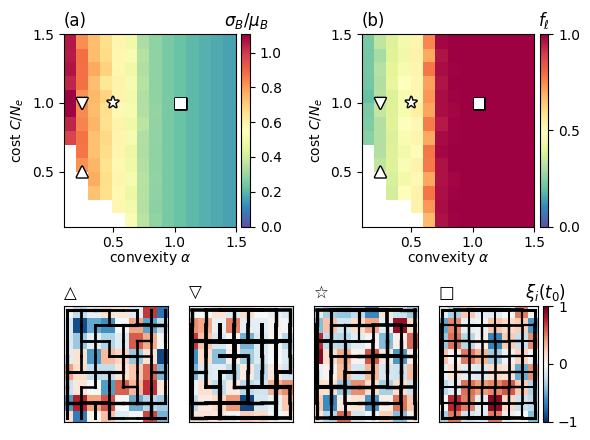

In [59]:
# Figure 1 v2
f = figure(figsize=(6, 4.5))

outer = gs.GridSpec(2, 1, f, height_ratios=[5, 3])
upper = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], wspace=0.6)
lower = gs.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[2], width_ratios=[95, 95, 95, 100])

############ Topology phase space
ax_d = subplot(upper[1])

divider = ag.make_axes_locatable(ax_d)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α, unique_b_tot)
im = ax_d[:pcolormesh](X, Y, mean_b_ratio, cmap="Spectral_r", vmin=0.0)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

# plot locations of networks
# ax_d[:plot]([α_1], [B_1], "*", c="w", mec="k", ms=10)
ax_d[:text](α_1*1.0, 1.0, STAR, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_2], [B_2], "*", c="w", mec="k", ms=10)
ax_d[:text](α_2*1.0, 0.5*1.0, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_3], [B_3], "*", c="w", mec="k", ms=10)
ax_d[:text](α_3*1.0, 1.0, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_4], [B_4], "*", c="w", mec="k", ms=10)
ax_d[:text](α_4*1.0, 1.0, BOX, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:set_xticks]([0, 1.5])
# ax_d[:set_yticks]([0, 1.5])

ax_d[:locator_params](axis="y", nbins=5)

ax_d[:set_xlabel](L"convexity $\alpha$", labelpad=-1)
ax_d[:set_ylabel](L"cost $C/N_e$")
ax_d[:set_title]("(a)", loc="left")


############ Topology phase space
ax_d = subplot(upper[2])

divider = ag.make_axes_locatable(ax_d)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α, unique_b_tot)
im = ax_d[:pcolormesh](X, Y, mean_loops, cmap="Spectral_r", vmin=0.0)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.5, 1])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

# plot locations of networks
# ax_d[:plot]([α_1], [B_1], "*", c="w", mec="k", ms=10)
ax_d[:text](α_1*1.0, 1.0, STAR, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_2], [B_2], "*", c="w", mec="k", ms=10)
ax_d[:text](α_2*1.0, 0.5*1.0, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_3], [B_3], "*", c="w", mec="k", ms=10)
ax_d[:text](α_3*1.0, 1.0, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:plot]([α_4], [B_4], "*", c="w", mec="k", ms=10)
ax_d[:text](α_4*1.0, 1.0, BOX, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_d[:set_xticks]([0, 1.5])
# ax_d[:set_yticks]([0, 1.5])

ax_d[:locator_params](axis="y", nbins=5)

ax_d[:set_xlabel](L"convexity $\alpha$", labelpad=-1)
ax_d[:set_ylabel](L"cost $C/N_e$")
ax_d[:set_title]("(b)", loc="left")



# ##################### Example networks
# srand(42)
ax_e = subplot(lower[3])

# draw_network_and_bg(ax_e, topol, b_final_1.^0.5, R)
# draw_network_py(ax_e, topol, 0.5b_final_1.^α_1, color="k", alpha=1.0)
im = draw_network_and_bg(ax_e, topol, b_final_1.^α_1, R_c, vmin=-1)
ax_e[:set_xticks]([])
ax_e[:set_yticks]([])

ax_e[:set_title](STAR_LG, loc="left")
# ax_e[:set_title](L"\alpha = 0.5")


ax_f = subplot(lower[1])

# draw_network_py(ax_f, topol, 0.5b_final_2.^α_2, color="k", alpha=1.0)
im = draw_network_and_bg(ax_f, topol, 1.5b_final_2.^α_2, R_c, vmin=-1)

ax_f[:set_xticks]([])
ax_f[:set_yticks]([])

ax_f[:set_title](TRIANG_UP_LG, loc="left")
# ax_f[:set_title](L"\alpha = 0.25")

ax_nw_3 = subplot(lower[2])

# draw_network_py(ax_nw_3, topol, b_final_3.^α_3, color="k", alpha=1.0)
im = draw_network_and_bg(ax_nw_3, topol, b_final_3.^α_3, R_c, vmin=-1)

ax_nw_3[:set_xticks]([])
ax_nw_3[:set_yticks]([])

ax_nw_3[:set_title](TRIANG_DOWN_LG, loc="left")


ax_nw_4 = subplot(lower[4])

# draw_network_py(ax_nw_4, topol, b_final_4.^α_4, color="k", alpha=1.0)
im = draw_network_and_bg(ax_nw_4, topol, b_final_4.^α_4, R_c, vmin=-1)

ax_nw_4[:set_xticks]([])
ax_nw_4[:set_yticks]([])

ax_nw_4[:set_title](BOX_LG, loc="left")

# colorbar
divider = ag.make_axes_locatable(ax_nw_4)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1, 0, 1])
cax[:set_title](L"\xi_i(t_0)")

########### SAVE
f[:tight_layout]()
f[:savefig]("paper_figs/supplement_white_noise_square.pdf", bbox_inches="tight")

In [60]:
α_ou_1 = 0.5
α_ou_2 = 0.5

τ_ou_1 = 0.1
τ_ou_2 = 10.0


# Ornstein-Uhlenbeck time correlations
b_final_ou_1, b_uniform_ou_1, obj_ou_1, obj_uniform_ou_1, obj_shuffled_ou_1 = optimize_ou_sync(topol, R, α_ou_1, 1./τ_ou_1*topol.γ)
b_final_ou_2, b_uniform_ou_2, obj_ou_2, obj_uniform_ou_2, obj_shuffled_ou_2 = optimize_ou_sync(topol, R, α_ou_2, 1./τ_ou_2*topol.γ)


α_ga_1 = 0.5
α_ga_2 = 0.5

σ_ga_1 = 0.1
σ_ga_2 = 0.3

R_ga_1 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_1)
R_ga_2 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_2)

R_ga_1_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_1, project=false)
R_ga_2_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_ga_2, project=false)

# Gaussian-Isotropic space correlations
b_final_ga_1, b_uniform_ga_1, obj_ga_1, obj_uniform_ga_1, obj_shuffled_ga_1 = optimize_wn_sync(topol, R_ga_1, α_ga_1)
b_final_ga_2, b_uniform_ga_2, obj_ga_2, obj_uniform_ga_2, obj_shuffled_ga_2 = optimize_wn_sync(topol, R_ga_2, α_ga_1)

final Δ: 9.458133474748087e-7
final Δ: 9.632281487460662e-7
final Δ: 9.790044753206101e-7
final Δ: 9.982440110243485e-7


([0.819043, 0.369443, 1.93831, 0.0, 2.52519, 3.54853, 2.21438, 0.0, 1.99837, 0.0  …  2.17404, 0.917319, 0.976813, 0.798137, 1.94111, 0.793531, 0.336809, 0.874763, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 2.4121052435583836, 3.7973723291207926, 5.1452853800203275)

In [61]:
# read in phase space data for time correlations
phase_space = readcsv("data/phase_diagram_ornstein_uhlenbeck_square_8.csv")

ps_α = phase_space[:,1]
ps_τ = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_α_ou, unique_τ_ou, mean_objective_ou, std_objective_ou = average_grid(ps_α, ps_τ, ps_objective)
unique_α_ou, unique_τ_ou, mean_loops_ou, std_loops_ou = average_grid(ps_α, ps_τ, ps_loop_fraction)
unique_α_ou, unique_τ_ou, mean_deg_ou, std_deg_ou = average_grid(ps_α, ps_τ, ps_mean_weighted_deg)


# compute the weight uniformity
b_final_results_ou = readcsv("data/phase_diagram_ornstein_uhlenbeck_square_8_networks.csv")
b_final_means_ou = mean(b_final_results_ou, 2)[:,1]
b_final_stds_ou = std(b_final_results_ou, 2)[:,1]

b_final_std_ratio_ou = b_final_stds_ou./b_final_means_ou

unique_α_ou, unique_τ_ou, mean_b_ratio_ou, std_b_ratio_ou = average_grid(ps_α, ps_τ, b_final_std_ratio_ou)
unique_τ_ou *= 0.5

15-element Array{Float64,1}:
   0.01     
   0.019307 
   0.0372759
   0.0719686
   0.13895  
   0.26827  
   0.517947 
   1.0      
   1.9307   
   3.72759  
   7.19686  
  13.895    
  26.827    
  51.7947   
 100.0      

In [62]:
# read in phase space data for gaussian spatial
phase_space = readcsv("data/phase_diagram_gaussian_square_8.csv")
netw_size_ga = 8.0

ps_α = phase_space[:,1]
ps_σ = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_α_ga, unique_σ_ga, mean_objective_ga, std_objective_ga = average_grid(ps_α, ps_σ, ps_objective)
unique_α_ga, unique_σ_ga, mean_loops_ga, std_loops_ga = average_grid(ps_α, ps_σ, ps_loop_fraction)
unique_α_ga, unique_σ_ga, mean_deg_ga, std_deg_ga = average_grid(ps_α, ps_σ, ps_mean_deg)

# compute the weight uniformity
b_final_results_ga = readcsv("data/phase_diagram_gaussian_square_8_networks.csv")
b_final_means_ga = mean(b_final_results_ga, 2)[:,1]
b_final_stds_ga = std(b_final_results_ga, 2)[:,1]

b_final_std_ratio_ga = b_final_stds_ga./b_final_means_ga

unique_α_ga, unique_σ_ga, mean_b_ratio_ga, std_b_ratio_ga = average_grid(ps_α, ps_σ, b_final_std_ratio_ga)

unique_σ_ga *= netw_size_ga;

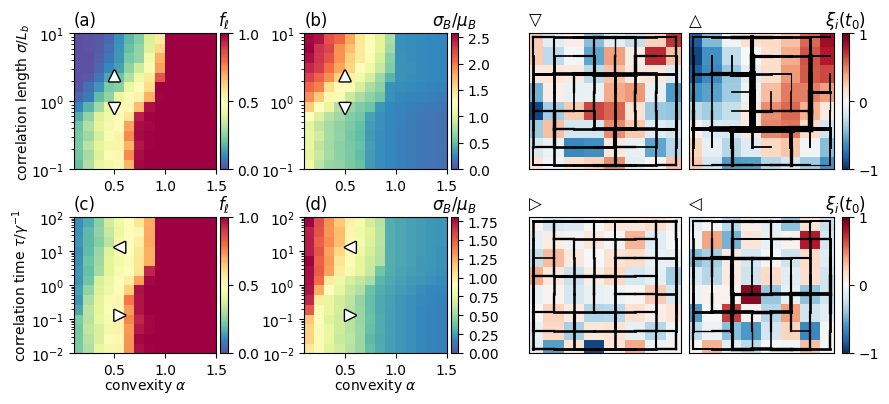

In [63]:
# f, axs = subplots(2, 4, figsize=(9., 4.))
# f = figure(figsize=(9, 4.))
f = figure(figsize=(10., 4.15))
top_base = gs.GridSpec(2, 2, f, hspace=0.35, wspace=0.2, width_ratios=[1.2, 1])

axs_ps_bot = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[1], wspace=0.5)
axs_netws_bot = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[2], wspace=0.05, width_ratios=[95, 100])

axs_ps_top = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[3], wspace=0.5)
axs_netws_top = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_base[4], wspace=0.05, width_ratios=[95, 100])


##### phase diagram loop topology Ornstein-Uhlenbeck
ax_b = subplot(axs_ps_top[1,1])
ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
ax_b[:set_ylabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
ax_b[:set_title]("(c)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ou, unique_τ_ou)
im = ax_b[:pcolormesh](X, Y, mean_loops_ou, cmap="Spectral_r", vmin=0.0)#, vmin=0, vmax=5)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.5, 1])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ou_1], [τ_ou_1], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, τ_ou_1*1.0, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:semilogy]([α_ou_2], [τ_ou_2], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, τ_ou_2*1.0, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:set_xticklabels]([])


##### phase diagram weight uniformity Ornstein-Uhlenbeck
ax_b = subplot(axs_ps_top[1,2])
ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
# ax_b[:set_ylabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
ax_b[:set_title]("(d)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ou, unique_τ_ou)
im = ax_b[:pcolormesh](X, Y, mean_b_ratio_ou, cmap="Spectral_r", vmin=0.0)#, vmin=0, vmax=5)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ou_1], [τ_ou_1], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, τ_ou_1*1.0, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:semilogy]([α_ou_2], [τ_ou_2], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, τ_ou_2*1.0, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()])

# ax_b[:set_xticklabels]([])
# ax_b[:set_yticklabels]([])

##### example networks Ornstein-Uhlenbeck
srand(42)
ax_c = subplot(axs_netws_top[1])
# draw_network_py(ax_c, topol, b_final_ou_1.^0.5, color="k", alpha=1.0)
im = draw_network_and_bg(ax_c, topol, 0.75b_final_ou_1.^α_ou_1, R_c, vmin=-1)
ax_c[:set_xticks]([])
ax_c[:set_yticks]([])

ax_c[:set_title](TRIANG_RIGHT_LG, loc="left")
# ax_c[:set_title](L"\tau = 100.0", fontsize=10)

ax_d = subplot(axs_netws_top[2])
# draw_network_py(ax_d, topol, b_final_ou_2.^0.5, color="k", alpha=1.0)
im = draw_network_and_bg(ax_d, topol, 0.75b_final_ou_2.^α_ou_2, R_c, vmin=-1)

ax_d[:set_title](TRIANG_LEFT_LG, loc="left")
# ax_d[:set_title](L"\tau = 0.01", fontsize=10)
ax_d[:set_xticks]([])
ax_d[:set_yticks]([])

# colorbar
divider = ag.make_axes_locatable(ax_d)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1,  0.0, 1])
cax[:set_title](L"\xi_i(t_0)")


######## phase diagram topology Gaussian Spatial
ax_b = subplot(axs_ps_bot[1])
# ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
ax_b[:set_ylabel](L"correlation length $\sigma/L_b$", labelpad=-0.5)
ax_b[:set_title]("(a)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ga, unique_σ_ga)
im = ax_b[:pcolormesh](X, Y, mean_loops_ga, cmap="Spectral_r")#, vmin=0, vmax=5)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, ticks=[0, 0.5, 1])
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ga_1], [σ_ga_1*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, σ_ga_1*8, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:semilogy]([α_ga_2], [σ_ga_2*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, σ_ga_2*8, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:set_xticklabels]([])

####### phase diagram weight uniformity Gaussian Spatial
ax_b = subplot(axs_ps_bot[2])
# ax_b[:set_xlabel](L"convexity $\alpha$", labelpad=-0.5)
# ax_b[:set_ylabel](L"correlation length $\log_{10}\sigma/L_b$")
ax_b[:set_title]("(b)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α_ga, unique_σ_ga)
im = ax_b[:pcolormesh](X, Y, mean_b_ratio_ga, cmap="Spectral_r", vmin=0)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_b[:set_yscale]("log")

# ax_b[:semilogy]([α_ga_1], [σ_ga_1*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_1*1.0, σ_ga_1*8, TRIANG_DOWN, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:semilogy]([α_ga_2], [σ_ga_2*10], "*", c="w", mec="k", ms=10)
ax_b[:text](α_ou_2*1.0, σ_ga_2*8, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:set_xticklabels]([])
# ax_b[:set_yticklabels]([])

###### Example networks Gaussian Spatial
srand(43)
ax_c = subplot(axs_netws_bot[1])
bg_R = OscillatorNetworks.isotropic_gaussian_correlation_matrix(bg_points, σ_ga_1)
im = draw_network_and_bg(ax_c, topol, 0.75b_final_ga_1.^0.5, R_ga_1_c; bg_method="nearest", bg_data=(bg_points, bg_R), vmin=-1)
ax_c[:set_title](TRIANG_DOWN_LG, loc="left")

ax_c = subplot(axs_netws_bot[2])
bg_R = OscillatorNetworks.isotropic_gaussian_correlation_matrix(bg_points, σ_ga_2)
im = draw_network_and_bg(ax_c, topol, 0.75b_final_ga_2.^0.5, R_ga_1_c; bg_method="nearest", bg_data=(bg_points, bg_R), vmin=-1)
ax_c[:set_title](TRIANG_UP_LG, loc="left")

# colorbar
divider = ag.make_axes_locatable(ax_c)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1, 0, 1])
cax[:set_title](L"\xi_i(t_0)")


f[:tight_layout]()
f[:savefig]("paper_figs/supplement_correlated_square.pdf", bbox_inches="tight")

In [64]:
α_st_1 = 0.5
α_st_2 = 0.5
α_st_3 = 0.5

σ_st_1 = 0.3/8
σ_st_2 = 0.3/8
σ_st_3 = 1.2/8

τ_st_1 = 0.1
τ_st_2 = 10.0
τ_st_3 = 1.0

R_st_1 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_1)
R_st_2 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_2)
R_st_3 = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_3)

R_st_1_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_1, project=false)
R_st_2_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_2, project=false)
R_st_3_c = OscillatorNetworks.isotropic_gaussian_correlation_matrix(topol, σ_st_3, project=false)

# combined
b_final_st_1, _, obj_st_1, _, _ = optimize_ou_sync(topol, R_st_1, α_st_1, 1./τ_st_1*topol.γ)
b_final_st_2, _, obj_st_2, _, _ = optimize_ou_sync(topol, R_st_2, α_st_2, 1./τ_st_2*topol.γ)
b_final_st_3, _, obj_st_3, _, _ = optimize_ou_sync(topol, R_st_3, α_st_3, 1./τ_st_3*topol.γ)

final Δ: 8.53137465823609e-7
final Δ: 9.837971999905927e-7
final Δ: 9.857998163461916e-7


([1.02633, 1.1188, 1.74614, 0.0, 2.59866, 0.0, 2.94327, 3.67789, 2.46061, 0.0  …  1.2348, 1.30019, 0.57501, 0.873659, 1.61745, 2.55641, 2.48328, 1.93423, 1.58731, 0.703848], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 2.8542954343386304, 4.660641770894066, 5.66746317492095)

In [65]:
# read in phase space data
phase_space = readcsv("data/phase_diagram_spatiotemporal_square_8.csv")

ps_τ = phase_space[:,1]
ps_σ = phase_space[:,2]
ps_objective = phase_space[:,3]
ps_loops = phase_space[:,4]
ps_max_loops = phase_space[:,5]

ps_mean_weighted_deg = phase_space[:,6]
ps_mean_deg = phase_space[:,8]

ps_loop_fraction = ps_loops./ps_max_loops;

unique_τ, unique_σ, mean_objective, std_objective = average_grid(ps_τ, ps_σ, ps_objective)
unique_τ, unique_σ, mean_loops, std_loops = average_grid(ps_τ, ps_σ, ps_loop_fraction)
unique_τ, unique_σ, mean_deg, std_deg = average_grid(ps_τ, ps_σ, ps_mean_deg)

# compute the weight uniformity
b_final_results = readcsv("data/phase_diagram_spatiotemporal_square_8_networks.csv")
b_final_means = mean(b_final_results, 2)[:,1]
b_final_stds = std(b_final_results, 2)[:,1]

b_final_std_ratio = b_final_stds./b_final_means

unique_τ, unique_σ, mean_b_ratio, std_b_ratio = average_grid(ps_τ, ps_σ, b_final_std_ratio)
unique_τ *= 0.5
unique_σ *= 8

15-element Array{Float64,1}:
  0.1     
  0.13895 
  0.19307 
  0.26827 
  0.372759
  0.517947
  0.719686
  1.0     
  1.3895  
  1.9307  
  2.6827  
  3.72759 
  5.17947 
  7.19686 
 10.0     

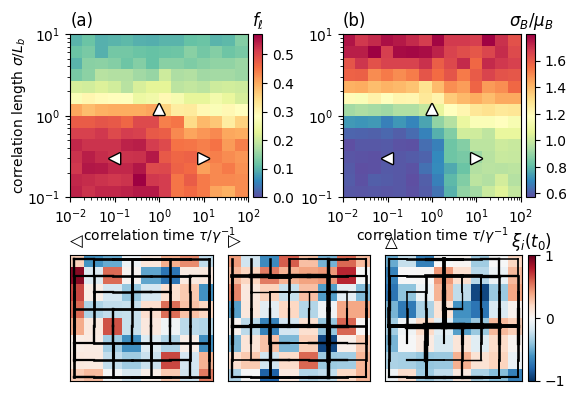

In [66]:
# Figure 3 v3
f = figure(figsize=(6, 4.5))

outer = gs.GridSpec(2, 1, f, hspace=0.4, wspace=0.3, height_ratios=[1.3, 1.0])
inner1 = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[1], hspace=0.3, wspace=0.42)
inner2 = gs.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[2], hspace=0.3, wspace=0.1, width_ratios=[95, 95, 100])

########## Phase diagram topology
ax_a = subplot(inner1[1])

ax_a[:set_xlabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
ax_a[:set_ylabel](L"correlation length $\sigma/L_b$", labelpad=-0.5)
ax_a[:set_title]("(a)", loc="left")

divider = ag.make_axes_locatable(ax_a)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_τ, unique_σ)
im = ax_a[:pcolormesh](X, Y, mean_loops, cmap="Spectral_r", vmin=0)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$f_\ell$")

ax_a[:set_xscale]("log")
ax_a[:set_yscale]("log")

# ax_a[:loglog]([τ_st_1], [σ_st_1*10], "*", c="w", mec="k", ms=10)
ax_a[:text](τ_st_1*1.0, σ_st_1*8, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_a[:loglog]([τ_st_2], [σ_st_2*10], "*", c="w", mec="k", ms=10)
ax_a[:text](τ_st_2*1.0, σ_st_2*8, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_a[:loglog]([τ_st_3], [σ_st_3*10], "*", c="w", mec="k", ms=10)
ax_a[:text](τ_st_3*1.0, σ_st_3*8, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

########## Phase diagram uniformity
ax_b = subplot(inner1[2])
ax_b[:set_xlabel](L"correlation time $\tau/\gamma^{-1}$", labelpad=-0.5)
# ax_b[:set_ylabel](L"correlation length $\log_{10}\sigma/L_b$")
ax_b[:set_title]("(b)", loc="left")

divider = ag.make_axes_locatable(ax_b)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_τ, unique_σ)
im = ax_b[:pcolormesh](X, Y, mean_b_ratio, cmap="Spectral_r")
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax)
# cb[:ax][:set_yticklabels](["0", "1", "2", "3", "4", L"\geq 5"])
cb[:ax][:set_title](L"$\sigma_B/\mu_B$")

ax_b[:set_xscale]("log")
ax_b[:set_yscale]("log")

# ax_b[:loglog]([τ_st_1], [σ_st_1*10], "*", c="w", mec="k", ms=10)
ax_b[:text](τ_st_1*1.0, σ_st_1*8, TRIANG_LEFT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:loglog]([τ_st_2], [σ_st_2*10], "*", c="w", mec="k", ms=10)
ax_b[:text](τ_st_2*1.0, σ_st_2*8, TRIANG_RIGHT, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")

# ax_b[:loglog]([τ_st_3], [σ_st_3*10], "*", c="w", mec="k", ms=10)
ax_b[:text](τ_st_3*1.0, σ_st_3*8, TRIANG_UP, color="w", path_effects=[path_effects.Stroke(linewidth=2, foreground="black"),
                       path_effects.Normal()], ha="center", va="center")


############## Example networks
srand(42)
ax_c = subplot(inner2[1])
draw_network_and_bg(ax_c, topol, 0.75b_final_st_1.^α_st_1, R_st_1_c; bg_method="nearest", vmin=-1)
ax_c[:set_title](TRIANG_LEFT_LG, loc="left")
# ax_c[:set_title](L"\sigma/L_b = 0.3, \tau=0.01", fontsize=10)

ax_d = subplot(inner2[2])
draw_network_and_bg(ax_d, topol, 0.75b_final_st_2.^α_st_2, R_st_2_c; bg_method="nearest", vmin=-1)
ax_d[:set_title](TRIANG_RIGHT_LG, loc="left")

ax_e = subplot(inner2[3])
im = draw_network_and_bg(ax_e, topol, 0.75b_final_st_3.^α_st_3, R_st_3_c; bg_method="nearest", vmin=-1)
ax_e[:set_title](TRIANG_UP_LG, loc="left")

# colorbar
divider = ag.make_axes_locatable(ax_e)
cax = divider[:append_axes]("right", size="5%", pad="5%")
f[:colorbar](im, cax=cax, ticks=[-1, 0.0, 1])
cax[:set_title](L"\xi_i(t_0)")

f[:tight_layout]()
f[:savefig]("paper_figs/supplement_spatiotemporal_square.pdf", bbox_inches="tight")

In [ ]:
## Performance factor
# read in phase space data
phase_space = readcsv("data/phase_diagram_white_noise_triang_10.csv")

ps_objective = phase_space[:,3]

fin = isfinite.(ps_objective)

ps_α = phase_space[fin,1]
ps_b_tot = phase_space[fin,2]

ps_objective = ps_objective[fin];

In [ ]:
@memoize function objective_uniform(α, b_tot)
    rhs = NetworkOptimization.white_noise_general
    b_total = float(topol.edges)*b_tot

    b_uniform = (b_total.*ones(topol.edges)/topol.edges).^(1./α)
        
    δ_uniform = OscillatorNetworks.ss_power_angles(b_uniform, topol)
    obj_uniform = NetworkOptimization.total_variance_white_noise(topol, R, b_uniform.*cos.(topol.E'*δ_uniform))
    
    return obj_uniform
end

In [ ]:
obj_uniforms = [objective_uniform(ps_α[i], ps_b_tot[i]) for i in 1:size(ps_α)[1]];

unique_α, unique_b, mean_factor, std_factor = average_grid(ps_α, ps_b_tot, ps_objective./obj_uniforms)

In [ ]:
f, ax = subplots(1, 1, figsize=(4, 3))


# ax = axs[1]
ax[:set_xlabel](L"convexity $\alpha$")
ax[:set_ylabel](L"cost $C$")

divider = ag.make_axes_locatable(ax)
cax = divider[:append_axes]("right", size="5%", pad="3%")

X, Y = np.meshgrid(unique_α, unique_b)
im = ax[:pcolormesh](X, Y, mean_factor, cmap="inferno_r", vmin=0, vmax=1)
im[:set_rasterized](true)

cb = f[:colorbar](im, cax=cax, label=L"\left. \langle|\varepsilon(t)|^2\rangle_{\mathrm{optimal}} \right/ \langle|\varepsilon(t)|^2\rangle_{\mathrm{uniform}}")

f[:tight_layout]()
f[:savefig]("paper_figs/supplement_improvement.pdf")